In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [3]:
# needed to put the Google data into a useful format
def reformat(infile, outfile, dictfile, min_year):
    
    raw = pd.read_csv(infile, delimiter='\t', names=["1gram", "year", "occ", "unused1", "unused2"], 
                      usecols=["1gram", "year", "occ"],
                      converters={"1gram":str, "year":int, "occ":int},
                      engine='c', quoting=3, encoding='latin-1')
    
    # break up each word into its own sub-array
    break_inds = np.where(raw["1gram"] != np.roll(raw["1gram"], 1))[0]
    
    years = np.array(raw["year"])
    years_each_word = np.array(np.split(years, break_inds[1:]))
    
    all_words = np.array(raw["1gram"])[break_inds]
    
    # only use data from words without "wacky" characters and that have appeared continuously
    usable_inds = []
    for index in range(years_each_word.size):
        try:
            if all_words[index] == all_words[index].encode("latin-1").decode("utf-8"):
                #if (years_each_word[index] - np.roll(years_each_word[index], 1) < 2).all():
                    #if years_each_word[index].min() <= 1800 and years_each_word[index].max() == 2008:
                usable_inds.append(index)
        except UnicodeDecodeError:
            print(f'WARNING - unicode decode error, ignoring word {index}...')
    
    if outfile:
        # writing the counts for each word
        
        years_each_word = years_each_word[usable_inds]
 
        counts = np.array(raw["occ"])
        counts_each_word = np.array(np.split(counts, break_inds[1:]))
        counts_each_word = counts_each_word[usable_inds]
        
        max_year = 2008
       
        for i in range(years_each_word.size):
            # get rid of years pre-min_year
            inds = np.where(years_each_word[i] >= min_year)
            years_each_word[i] = years_each_word[i][inds]
            counts_each_word[i] = counts_each_word[i][inds]
    
        # axes (word, year)
        full_counts_each_word = np.zeros((len(usable_inds), max_year-min_year+1))
        
        for i in range(full_counts_each_word.shape[0]):
            full_counts_each_word[i][years_each_word[i].astype(np.int32)-min_year] = counts_each_word[i]

        # write counts
        with open(outfile, 'ba') as f:
            np.savetxt(f, full_counts_each_word, fmt='%u', delimiter=',')
    
    if dictfile:

        usable_words = all_words[usable_inds]

        # write words to ordered "dictionary"
        with open(dictfile, 'a+') as f:
            for word in usable_words:
                f.write(word)
                f.write('\n')
                
# to get a count of how many of each word is used in a book
def get_words(dictfile, bookfile):
    
    # read a dictionary file, an ordered list of strings
    # ordered the same as the words are in the data
    with open(dictfile, 'r') as f:
        dct = f.read().splitlines()
    
    with open(bookfile, 'r') as file:
        book = file.read().replace('\n', ' ')

    # we read the book and count how many times each word in our dictionary appears

    raw_words = book.split()
    word_counts = Counter(raw_words)

    words = np.zeros(np.size(dct))
    for i, word in enumerate(dct):
        words[i] += word_counts[word]
        
    return words

In [4]:
# now some stuff we need for Bayesian stats...

def norm_data(data):
    
    # ensure multinomial coeffs for each year sum to 1
    norm = np.sum(data, axis=0)
    
    print('sum ok.')
    
    return data / norm

def likelihood(years, words, data):
    
    # get probability that all of words were picked given data at year, for each year
    
    print('norm ok.')
    
    # axes of data are (word, year). loop over years (to sacrifice speed for memory)
    multinom = np.zeros_like(data[0])
    
    print('zeros ok.')
    
    for i in range(data[0].size):
        
        multinom[i] = np.sum(words*np.log(data[:,i]))
    
    print('multinom ok.')
    
    # get normalization factor
    norm = np.sum(multinom*dx)
    print(norm)
    
    print('overall norm ok.')
    
    return multinom
    
def exp_prior(years):
    
    # an arbitrary exponential prior
    # to capture greater number of publications in recent years
    
    return np.log(np.exp(0.01*years)) / (np.sum(np.log(np.exp(0.01*years)))*dx)

def uni_prior(years):
    
    return np.zeros_like(years)

def posterior(years, words, data):
    
    # feel free to swap the priors and see what changes
    post = likelihood(years, words, data) + uni_prior(years)
    
    norm = np.sum(post*dx)
    
    return post 

In [5]:
# start by downloading the Google Ngram "English 1 Million" dataset (the 1grams only)
# put them in a folder ../ngram_data relative to where this script lives
# 
# then, run the next cell *once* (you may want to go for a walk or something)
# if you run it again, choose different file names, as the program appends

# furthest in the past you wish to delve
min_year = 1800
# file names
outfile = "../ngram_data/full_counts_nice.csv"
dictfile = "../ngram_data/py_dict_nice.txt"

In [12]:
# we put the Google data in a usable format in these files
for i in range(10):
    name = f"../ngram_data/googlebooks-eng-1M-1gram-20090715-{i}.csv"
    reformat(name, outfile, dictfile, min_year)
    print(f"done file {i}/9")

done file 0/9
done file 1/9
done file 2/9
done file 3/9
done file 4/9
done file 5/9
done file 6/9
done file 7/9
WARNING - unicode decode error, ignoring word 0...
done file 8/9
done file 9/9


In [13]:
# now, find (or write) a book and put it into a .txt file
bookfile = '../ngram_data/new.txt'

words = get_words(dictfile, bookfile)

In [10]:
# now we read the data again
# but we won't lose it forever if (when) the kernel dies
# try to have as little else running as possible when you do these next steps

data = pd.read_csv(outfile, delimiter=',', dtype=np.int32, header=None).values
# this was my fix for being able to work in logspace
# it seems reasonable, as these are the 1 million most common words
data += 1

In [11]:
# the fun step!
# note we are working with logarithmic probability

dx = 1
years = np.arange(1800, 2008+1, dx)

# generate posterior

post = posterior(years, words, norm_data(data))

sum ok.
norm ok.
zeros ok.
multinom ok.
-13886.583288697442
overall norm ok.


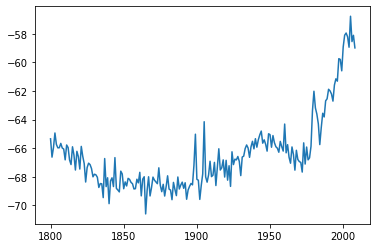

In [12]:
# make nice plots

plt.plot(years, post)
plt.show()